In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [x] Предобработка данных
- [x] Анализ данных о регистрациях и займах
- [x] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] Срок займа: план-факт + динамика
- [x] Категоризация займов по реальному сроку пользования деньгами
- [x] Исследование суммы займов
- [x] Когортный анализ:
    - [x] User Retention
    - [x] Ср.кол-во займов нарастающим итогом
    - [x] Ср.сумма займа нарастающим итогом
    - [x] ARPU
    - [x] Ретеншен капитала
    - [x] NPL

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs = pd.read_excel('regs.xlsx')
loans = pd.read_excel('loans.xlsx')

## Предобработка данных

### Регистрации

In [3]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557663 entries, 0 to 557662
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cid              557663 non-null  int64 
 1   uid              536732 non-null  object
 2   ts               557663 non-null  object
 3   is_reg_complete  557663 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 17.0+ MB


In [4]:
# изучим срез данных
regs.sample(5)

,cid,uid,ts,is_reg_complete
284678,1190644,708508B2-5A20-4B2D-B68B-CC3989842AA9,2019-08-02 06:48:27.0434509,1
510810,1429644,DB444F38-790D-4F4D-8FB9-F56155207D62,2020-09-30 20:46:09.5776128,1
317967,1228445,77665ADE-8C70-4FD7-9F7E-E9B46B9D03C7,2019-10-29 09:36:25.9208501,1
53809,943726,NaN,2019-02-07 22:00:22.2433333,1
49248,939163,EC60B1BC-9C6A-4462-A2E2-A1E25B903508,2019-02-05 23:42:26.0200000,1


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>ts</b> - время начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [5]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
regs.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в ts
regs['ts'] = regs['ts'].astype('datetime64[D]')

# переименуем также один столбец
regs.rename(columns={'ts': 'reg_ts'}, inplace=True)

# проверяем
regs.sample(5)

,cid,reg_ts,is_reg_complete
98084,990135,2019-03-07,0
308561,1218541,2019-10-22,1
513142,1431976,2020-10-03,1
145238,1037802,2019-04-11,1
2088,890951,2019-01-04,1


In [6]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_ts             0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [7]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128864 entries, 0 to 128863
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cid       128864 non-null  int64  
 1   uid       126392 non-null  object 
 2   start_ts  128864 non-null  object 
 3   value     128864 non-null  float64
 4   term      128864 non-null  int64  
 5   status    128864 non-null  object 
 6   end_ts    89847 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.9+ MB


In [8]:
# изучим срез данных
loans.sample(5)

,cid,uid,start_ts,value,term,status,end_ts
35774,817346,3830EA2B-49F3-4440-A240-5F167D2B5609,2019-03-26 00:00:00.0000000,20000.0,30,Погашен,2019-05-18 23:59:59.9990000
46762,1039422,NaN,2019-05-02 00:00:00.0000000,3000.0,16,Погашен,2019-05-11 23:59:59.9990000
48228,1075686,39DB2882-D1DB-4355-BCF4-D22DA79C113F,2019-05-11 00:00:00.0000000,19822.0,30,Погашен,2019-08-31 23:59:59.9990000
74889,1213870,EAC50C54-91B1-45EF-81B4-55BAFB2106DB,2019-10-18 00:00:00.0000000,15540.0,56,Погашен,2019-12-16 23:59:59.9999999
95097,1107020,350B92A9-6B97-4DEF-91BE-417496BB41F2,2020-06-05 00:00:00.0000000,11500.0,30,Погашен,2020-07-04 23:59:59.9999999


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>start_ts</b> - время получения займа<br>
<b>value</b> - сумма<br>
<b>term</b> - срок<br>
<b>status</b> - статус на текущий момент<br>
<b>end_ts</b> - время возврата займа

In [9]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
loans.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в столбце start_ts, end_ts
loans['end_ts'] = loans['end_ts'].astype('datetime64[D]')
loans['start_ts'] = loans['start_ts'].astype('datetime64[D]')

# проверяем
loans.sample(5)

,cid,start_ts,value,term,status,end_ts
82964,1028313,2019-12-24,12000.0,56,Погашен,2020-02-18
21345,904757,2019-02-15,8000.0,17,На цессии,NaT
122269,1447062,2020-11-05,11000.0,31,Погашен,2020-12-02
52769,1050301,2019-05-27,14000.0,30,Погашен,2019-06-02
107117,1396312,2020-08-26,13800.0,42,Просрочен,NaT


In [10]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid             0
start_ts        0
value           0
term            0
status          0
end_ts      39017
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <li> пропупуски есть в столбце end_ts и это нормально т.к. у нас есть незакрытые займы
    <li> дубликатов нет
</div>
Переходоим к анализу данных

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [11]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['reg_date'] = regs['reg_ts'].astype('datetime64[D]')
regs['reg_week'] = regs['reg_ts'].dt.to_period('W').apply(lambda r: r.start_time)
regs['reg_month'] = regs['reg_ts'].astype('datetime64[M]')

# проверяем
regs.head()

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month
0,889241,2019-01-01,1,2019-01-01,2018-12-31,2019-01-01
1,888861,2019-01-01,1,2019-01-01,2018-12-31,2019-01-01
2,888862,2019-01-01,1,2019-01-01,2018-12-31,2019-01-01
3,888863,2019-01-01,1,2019-01-01,2018-12-31,2019-01-01
4,888864,2019-01-01,1,2019-01-01,2018-12-31,2019-01-01


In [12]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,40734,34703
2019-02-01,48637,41849
2019-03-01,41833,35433
2019-04-01,42527,31513
2019-05-01,42569,31016
2019-06-01,34171,24573
2019-07-01,33755,24873
2019-08-01,10708,8377
2019-09-01,5168,4245


#### 1.2 Групиировка данных о займах

In [13]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['loan_date'] = loans['start_ts'].dt.date
loans['loan_week'] = loans['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
loans['loan_month'] = loans['start_ts'].astype('datetime64[M]')

# проверяем
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month
0,764990,2019-01-01,17000.0,14,Погашен,2019-01-14,2019-01-01,2018-12-31,2019-01-01
1,875870,2019-01-01,8000.0,30,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01
2,646072,2019-01-01,12000.0,30,Погашен,2019-01-21,2019-01-01,2018-12-31,2019-01-01
3,747636,2019-01-01,20000.0,14,Погашен,2019-01-30,2019-01-01,2018-12-31,2019-01-01
4,888956,2019-01-01,11000.0,19,Погашен,2019-01-19,2019-01-01,2018-12-31,2019-01-01


In [14]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,11051
2019-02-01,7560
2019-03-01,4245
2019-04-01,3779
2019-05-01,3026
2019-06-01,1719
2019-07-01,3485
2019-08-01,2007
2019-09-01,1535


In [15]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,14045
2019-02-01,12677
2019-03-01,10698
2019-04-01,9113
2019-05-01,7452
2019-06-01,4886
2019-07-01,6024
2019-08-01,4440
2019-09-01,4083


In [16]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,14045,11051,2994
2019-02-01,12677,7560,5117
2019-03-01,10698,4245,6453
2019-04-01,9113,3779,5334
2019-05-01,7452,3026,4426
2019-06-01,4886,1719,3167
2019-07-01,6024,3485,2539
2019-08-01,4440,2007,2433
2019-09-01,4083,1535,2548


#### 1.3 Объеденение данных в обну таблицу

In [17]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
reg_month,,,,,
2019-01-01,40734,34703,14045,11051,2994
2019-02-01,48637,41849,12677,7560,5117
2019-03-01,41833,35433,10698,4245,6453
2019-04-01,42527,31513,9113,3779,5334
2019-05-01,42569,31016,7452,3026,4426
2019-06-01,34171,24573,4886,1719,3167
2019-07-01,33755,24873,6024,3485,2539
2019-08-01,10708,8377,4440,2007,2433
2019-09-01,5168,4245,4083,1535,2548


#### 1.4 Графики

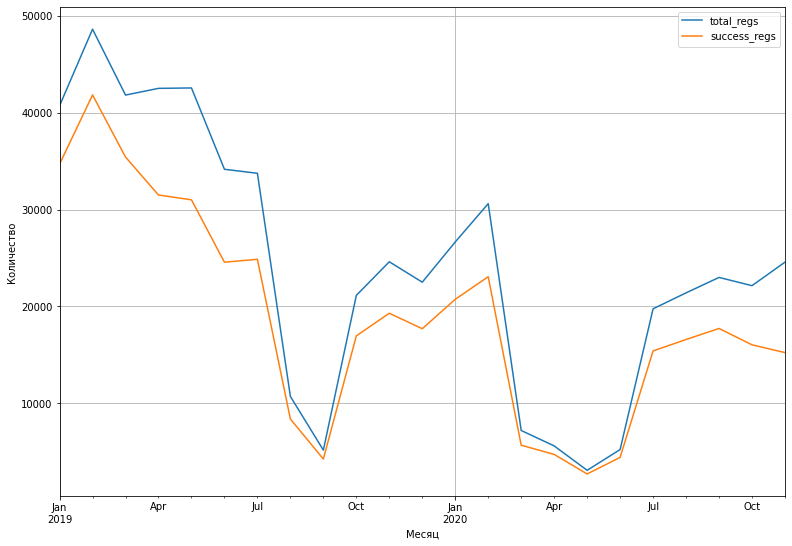

In [18]:
# построим график динамики регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

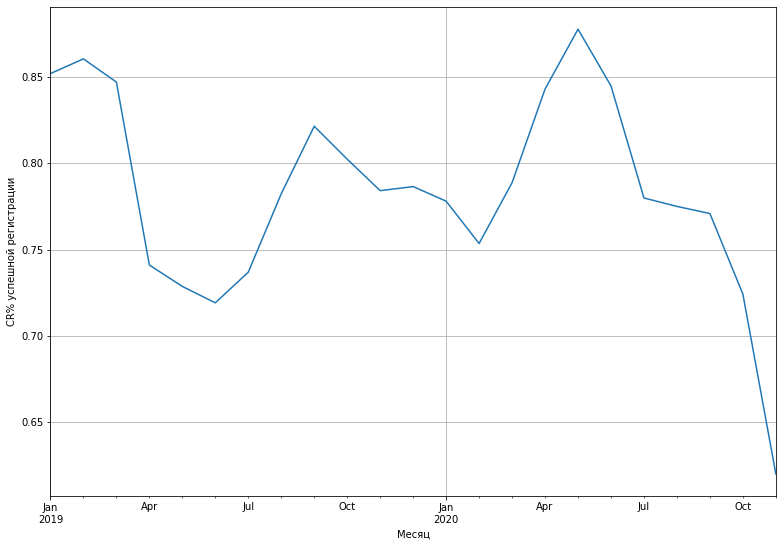

In [19]:
# а также ихучим конверсию из всех регистраций в успешные
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>количетсво регистраций (всех/успешных) стабильно сокращалось с апрелья 2019 года
        <li>при этом конверсия в успешную регистрацию за этот же период показала стабильный рост и достигла порядка 70%
    </ul>
</div>

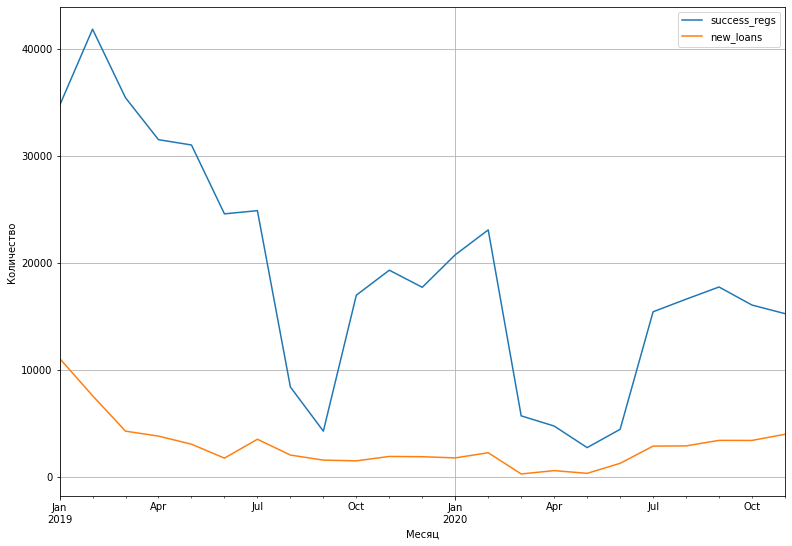

In [20]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

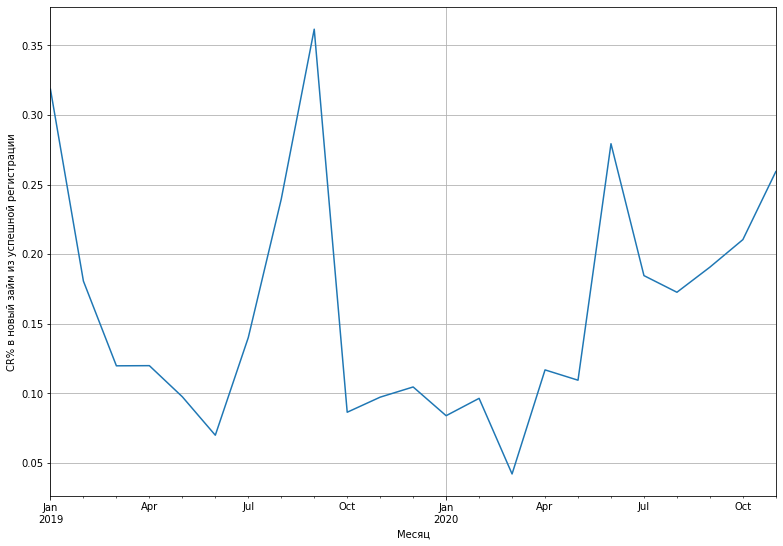

In [21]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>при стабильном сокращении успешных регистраций кол-во новых займов осталось практически на том же уровне
        <li>можно констатировать, что произошло это в первую очередь за счет роста конверсии в новый заем с 15% до 25%
        <li>однако это общие данные, которые состаят из различных источников трафика в тч высококонверсионной органики (в тч брендовой). Судя по данным из affise CPA канал в августе имел CR = 17%
    </ul>
</div>

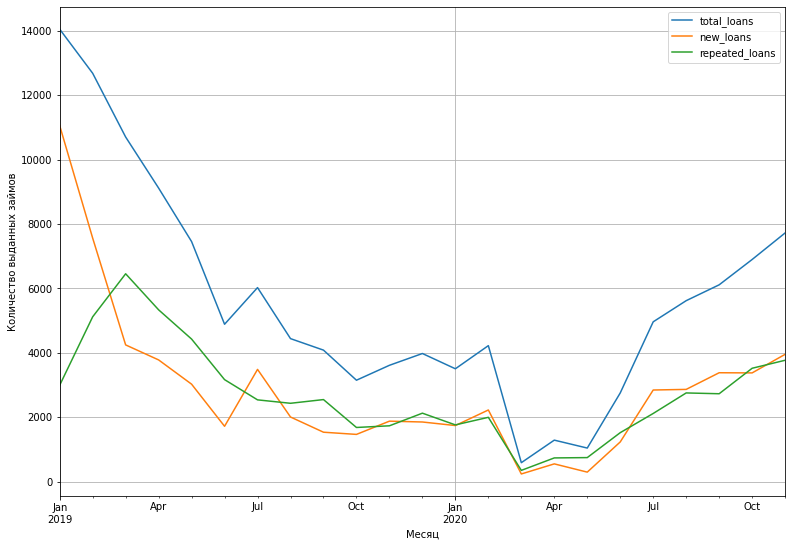

In [22]:
# посмотрим на долю потворных займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>ближе к концу анализируемого периода наблюдается рост общего количества выданных займов
        <li>происходит это за счет роста повторных выдач. Это хороший для нас показатель
        <li>доля вопвторных займов колеблется в диапазоне 60%-70%
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [23]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'start_ts': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'start_loan']

# проверяем
first_loan_ts.head()

,cid,start_loan
0,2056,2019-07-05
1,2307,2019-07-09
2,2385,2019-01-03
3,2489,2019-01-26
4,2544,2019-01-31


In [24]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan
35060,924944,2019-01-28,1,2019-01-28,2019-01-28,2019-01-01,NaT
255025,1159767,2019-07-05,1,2019-07-05,2019-07-01,2019-07-01,2019-07-05
193899,1093278,2019-05-21,1,2019-05-21,2019-05-20,2019-05-01,NaT
111743,1003805,2019-03-18,1,2019-03-18,2019-03-18,2019-03-01,NaT
428031,1344775,2020-03-04,1,2020-03-04,2020-03-02,2020-03-01,NaT
437024,1353778,2020-04-20,0,2020-04-20,2020-04-20,2020-04-01,NaT
522634,1441467,2020-10-16,1,2020-10-16,2020-10-12,2020-10-01,NaT
284530,1190496,2019-08-01,1,2019-08-01,2019-07-29,2019-08-01,NaT
460965,1377781,2020-07-21,0,2020-07-21,2020-07-20,2020-07-01,NaT
362302,1274879,2019-12-24,1,2019-12-24,2019-12-23,2019-12-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [25]:
# удаляем лишние строки
time_to_loan.dropna(subset=['start_loan'], inplace=True)

In [26]:
# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['start_loan'] - time_to_loan['reg_ts']).dt.days

time_to_loan.sample(10)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan,days_to_loan
180873,1079786,2019-05-15,1,2019-05-15,2019-05-13,2019-05-01,2019-10-26,164
36518,926408,2019-01-29,1,2019-01-29,2019-01-28,2019-01-01,2019-01-29,0
213598,1113768,2019-05-30,1,2019-05-30,2019-05-27,2019-05-01,2019-05-30,0
77664,969590,2019-02-21,1,2019-02-21,2019-02-18,2019-02-01,2019-02-22,1
317528,1228006,2019-10-28,1,2019-10-28,2019-10-28,2019-10-01,2019-10-28,0
158032,1051604,2019-04-17,1,2019-04-17,2019-04-15,2019-04-01,2019-04-17,0
297400,1205962,2019-09-16,1,2019-09-16,2019-09-16,2019-09-01,2019-09-16,0
5875,894743,2019-01-08,1,2019-01-08,2019-01-07,2019-01-01,2019-02-14,37
458337,1375152,2020-07-18,1,2020-07-18,2020-07-13,2020-07-01,2020-07-18,0
86070,978119,2019-02-26,1,2019-02-26,2019-02-25,2019-02-01,2019-02-27,1


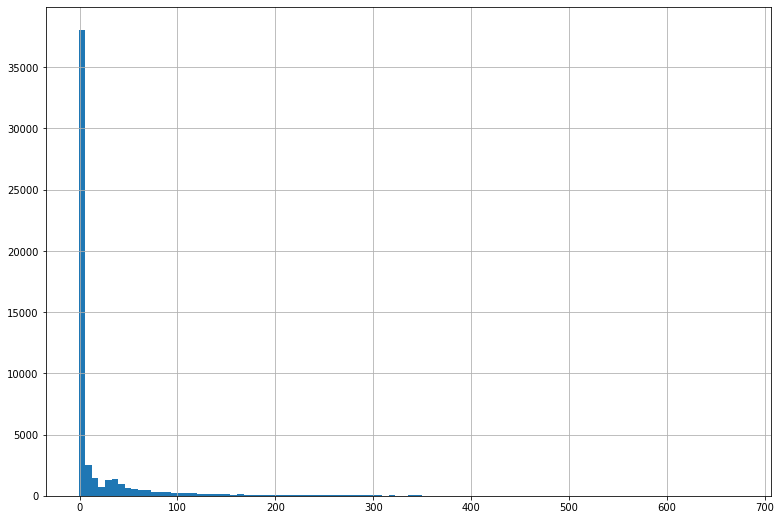

In [27]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

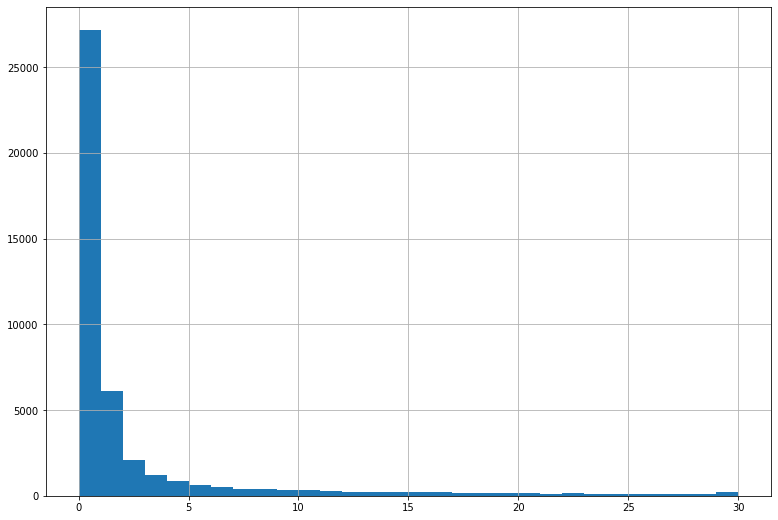

In [28]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [29]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     27170
1      6094
2      2080
3      1205
4       866
5       637
6       510
7       425
31      388
8       376
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>львиная доля клиентов получают свой первый заем в день регистрации
        <li>кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li>есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li>чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li>в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [30]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_ts'] - loans['start_ts']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term
11765,816342,2019-01-27,4000.0,20,Погашен,2019-02-07,2019-01-27,2019-01-21,2019-01-01,11
74565,910241,2019-10-15,5000.0,10,Погашен,2019-10-22,2019-10-15,2019-10-14,2019-10-01,7
33651,251545,2019-03-19,18000.0,30,Погашен,2019-09-08,2019-03-19,2019-03-18,2019-03-01,173
115086,1425491,2020-10-05,2185.0,12,Погашен,2020-10-16,2020-10-05,2020-10-05,2020-10-01,11
115119,1366882,2020-10-05,7700.0,26,Погашен,2020-10-31,2020-10-05,2020-10-05,2020-10-01,26
90626,889252,2020-02-20,20000.0,56,Погашен,2020-04-16,2020-02-20,2020-02-17,2020-02-01,56
102904,1383714,2020-08-03,9775.0,40,Погашен,2020-10-26,2020-08-03,2020-08-03,2020-08-01,84
8073,911694,2019-01-19,18000.0,30,Погашен,2019-01-30,2019-01-19,2019-01-14,2019-01-01,11
117274,218278,2020-10-15,11500.0,40,Погашен,2020-11-26,2020-10-15,2020-10-12,2020-10-01,42
48975,707195,2019-05-14,3000.0,16,Погашен,2019-05-20,2019-05-14,2019-05-13,2019-05-01,6


In [31]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 2,508,931 дня(ей)
Фактически с учетом досрочных погашений и просрочек деньгами пользовались 3,085,806 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 862,699 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

count    89847.000000
mean        27.924483
std         14.421944
min          1.000000
25%         18.000000
50%         30.000000
75%         30.000000
max        168.000000
Name: term, dtype: float64

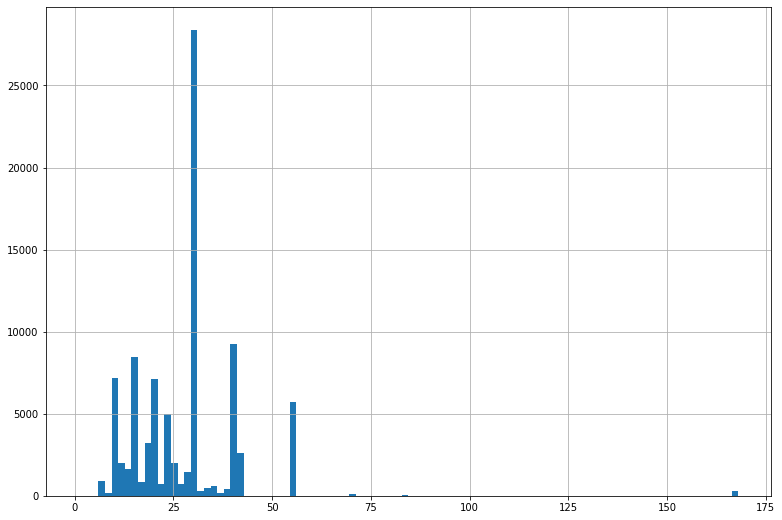

In [32]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    89847.000000
mean        34.345120
std         41.198839
min          0.000000
25%          9.000000
50%         23.000000
75%         42.000000
max        656.000000
Name: real_term, dtype: float64

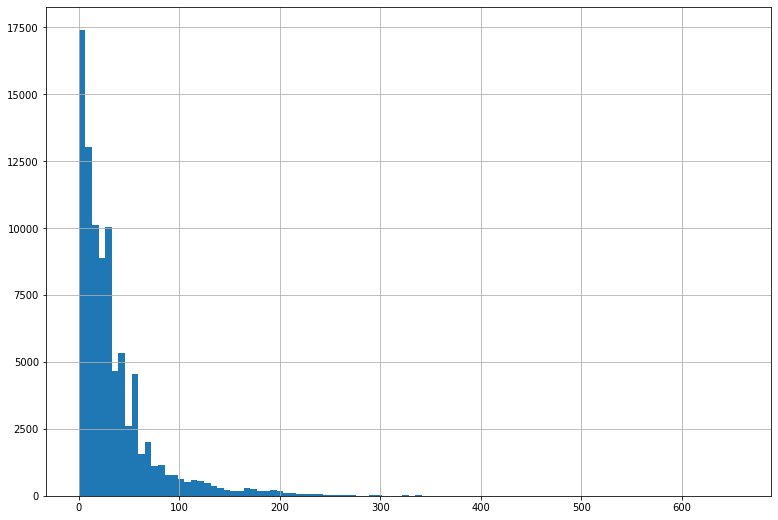

In [33]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [34]:
# ТОП5 запрашиваемых сроков
real_term['term'].value_counts().head()

30    27637
40     9236
16     7023
10     6641
20     5768
Name: term, dtype: int64

In [35]:
# ТОП5 фактических сроков
real_term['real_term'].value_counts().head()

1     3239
0     3117
30    3076
2     2559
10    2420
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li>также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li>среднее значение фактического пользования займом = 32.66 дня, средний запрашиваемый срок = 29.55 дня
        <li>медианное значение больше уже у запрашиваемых показателй - 30 дней против 20 дней. Т.е. 50% займов закрываются в срок до 20 дней
        <li>в ТОП5 значений фактического пользования займами есть 2 не очень хороших значения - это 0 день (погашение в день получения займа) и 1 (погашение на следующий день)
        <li>25% займов погашаются до 8 дней, 50% до 20 дней, 75% до 42 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

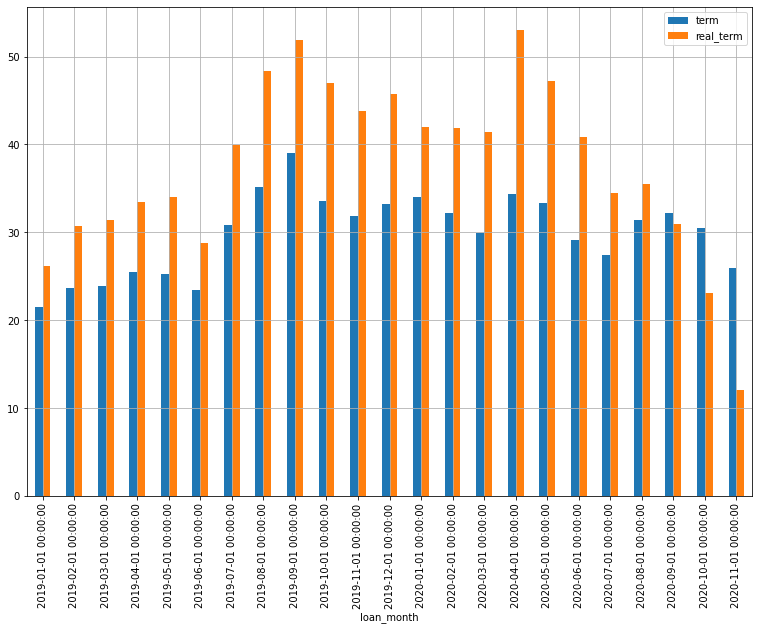

In [36]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li>в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li>начиная с июля график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li>в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [37]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [38]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category
76076,1222295,2019-10-28,2000.0,11,Погашен,2019-10-29,2019-10-28,2019-10-28,2019-10-01,1.0,Досрочно
41976,1044601,2019-04-15,14000.0,16,На цессии,NaT,2019-04-15,2019-04-15,2019-04-01,NaN,Не закрыт
85612,1291450,2020-01-15,2000.0,10,Погашен,2020-01-16,2020-01-15,2020-01-13,2020-01-01,1.0,Досрочно
45804,851862,2019-04-27,10300.0,16,Погашен,2019-05-20,2019-04-27,2019-04-22,2019-04-01,23.0,С просрочкой
106166,1395589,2020-08-22,11500.0,42,Погашен,2020-10-25,2020-08-22,2020-08-17,2020-08-01,64.0,С просрочкой
27234,983992,2019-03-02,15000.0,25,Погашен,2019-03-07,2019-03-02,2019-02-25,2019-03-01,5.0,Досрочно
53075,621179,2019-05-28,7800.0,20,На цессии,NaT,2019-05-28,2019-05-27,2019-05-01,NaN,Не закрыт
96644,1152339,2020-06-22,14500.0,25,Просрочен,NaT,2020-06-22,2020-06-22,2020-06-01,NaN,Не закрыт
105411,1392424,2020-08-18,5000.0,40,Погашен,2020-09-27,2020-08-18,2020-08-17,2020-08-01,40.0,В срок
54691,671349,2019-06-05,16000.0,30,Погашен,2019-10-25,2019-06-05,2019-06-03,2019-06-01,142.0,С просрочкой


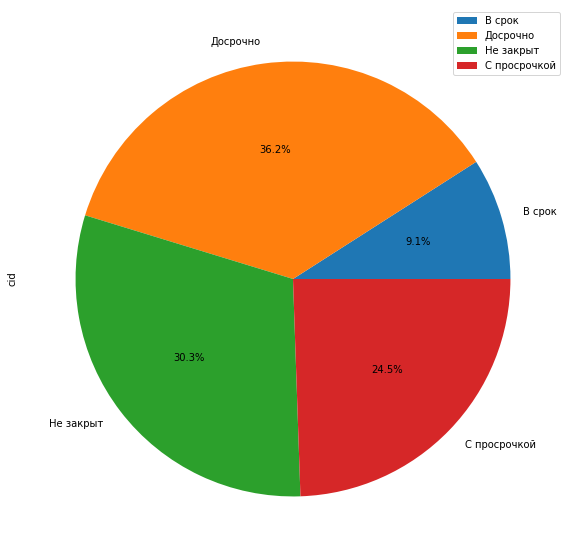

In [39]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

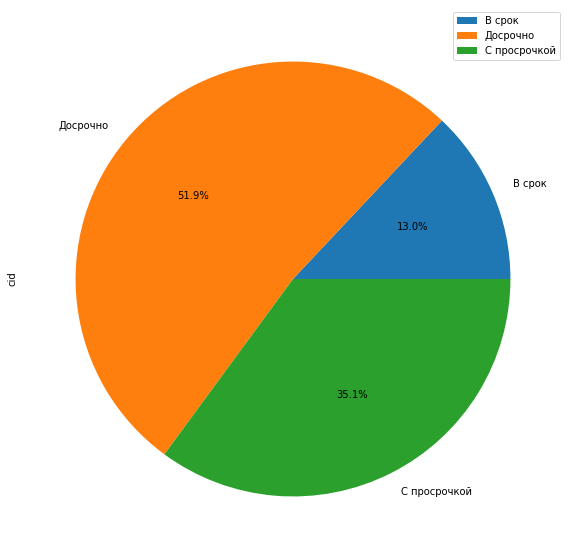

In [40]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>27.4% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li>Если анализировать уже закрытые займы - 55.6% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [41]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum().round(0):,} рублей')

Суммарные выдачи за анализируемый период составили 1,374,647,153.0 рублей


In [42]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    128864.000000
mean      10667.425760
std        6115.466691
min          10.000000
25%        5100.000000
50%       10000.000000
75%       15000.000000
max       80500.000000
Name: value, dtype: float64

In [43]:
# TOP10 частотность
loans['value'].value_counts().head(10)

20000.0    10977
10000.0     7120
12000.0     5558
8000.0      5422
4000.0      4872
5000.0      4558
3500.0      3536
6500.0      3425
18000.0     3331
14000.0     3228
Name: value, dtype: int64

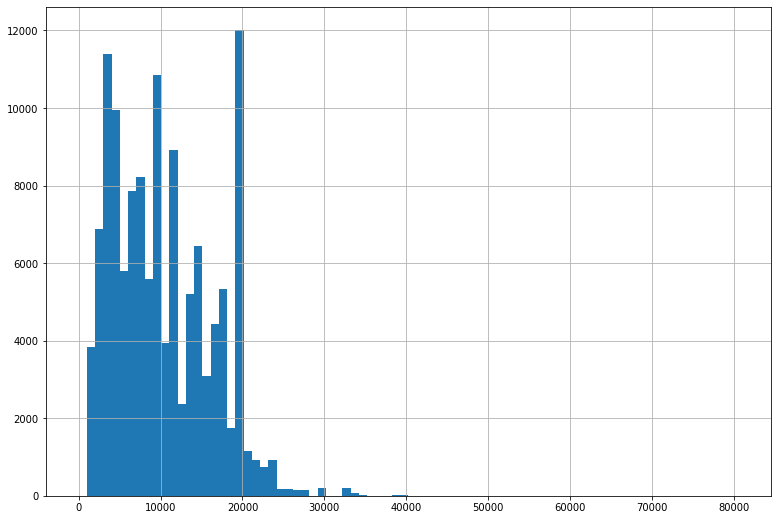

In [44]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=80);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>общая сумма выданных средств за анализируемый период 3 683 503 741 рубля
        <li>средняя выдача - 9648 рублей
        <li>первый-третий квартили: 4500, 8000, 12000. Это значит, что 25% займов оформляются на сумму, меньше 4500р, 50% займов на сумму до 8000 и 75% займов на сумму до 12000 рублей.
        <li>чаще всего берут займ на 8000 рублей (28526 раз)
        <li>в ТОП10 значений по частоте 7 значений меньше 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [45]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,155680200.0,14045,11084
2019-02-01,139387100.0,12677,10995
2019-03-01,123693100.0,10698,11562
2019-04-01,106361410.0,9113,11671
2019-05-01,88298444.2,7452,11848
2019-06-01,50446079.0,4886,10324
2019-07-01,59994628.0,6024,9959
2019-08-01,49664621.0,4440,11185
2019-09-01,51923231.0,4083,12716


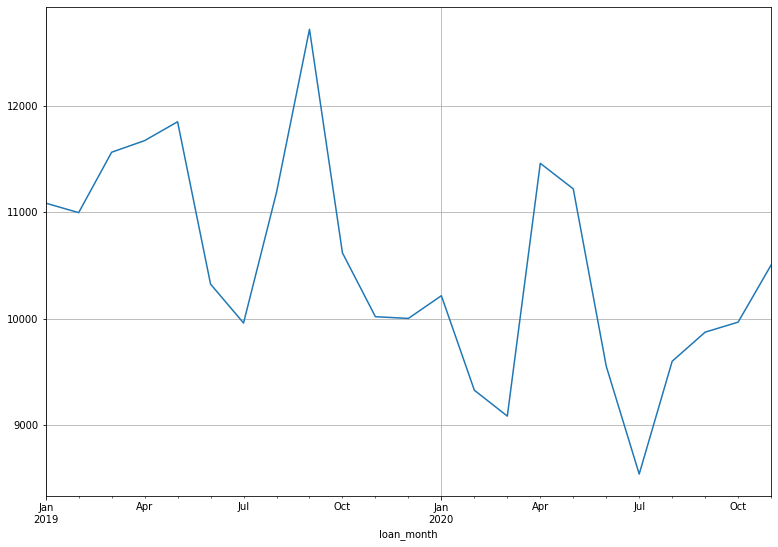

In [46]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [47]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное занчение 8541 рубл.
Максимальное занчение 12716 руб.


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>мин-макс средние значения находятся в диапазоне от 8154 руб до 10672 руб
        <li>не прослеживается какой-либо тренд на рост-падение, есть только периодические колебания на 10-20%
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [48]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,2056,2019-07-01
1,2307,2019-07-01
2,2385,2019-01-01
3,2489,2019-01-01
4,2544,2019-01-01
...,...,...
66304,1477430,2020-11-01
66305,1477439,2020-11-01
66306,1477490,2020-11-01
66307,1477512,2020-11-01


In [49]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,764990,2019-01-01,17000.0,14,Погашен,2019-01-14,2019-01-01,2018-12-31,2019-01-01,13.0,Досрочно,2019-01-01,0
1,764990,2019-01-16,20000.0,8,Погашен,2019-01-24,2019-01-16,2019-01-14,2019-01-01,8.0,В срок,2019-01-01,0
2,764990,2019-01-25,20000.0,16,Погашен,2019-02-09,2019-01-25,2019-01-21,2019-01-01,15.0,Досрочно,2019-01-01,0
3,875870,2019-01-01,8000.0,30,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01,NaN,Не закрыт,2019-01-01,0
4,646072,2019-01-01,12000.0,30,Погашен,2019-01-21,2019-01-01,2018-12-31,2019-01-01,20.0,Досрочно,2019-01-01,0


In [50]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,11051
1,2019-01-01,1,3234
2,2019-01-01,2,2325
3,2019-01-01,3,1556
4,2019-01-01,4,1099
...,...,...,...
271,2020-09-01,1,595
272,2020-09-01,2,554
273,2020-10-01,0,3376
274,2020-10-01,1,628


In [51]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,11051
23,2019-02-01,7560
45,2019-03-01,4245
66,2019-04-01,3779
86,2019-05-01,3026
105,2019-06-01,1719
123,2019-07-01,3485
140,2019-08-01,2007
156,2019-09-01,1535
171,2019-10-01,1467


In [52]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,11051,11051,1.000000
1,2019-01-01,1,3234,11051,0.292643
2,2019-01-01,2,2325,11051,0.210388
3,2019-01-01,3,1556,11051,0.140802
4,2019-01-01,4,1099,11051,0.099448


In [53]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

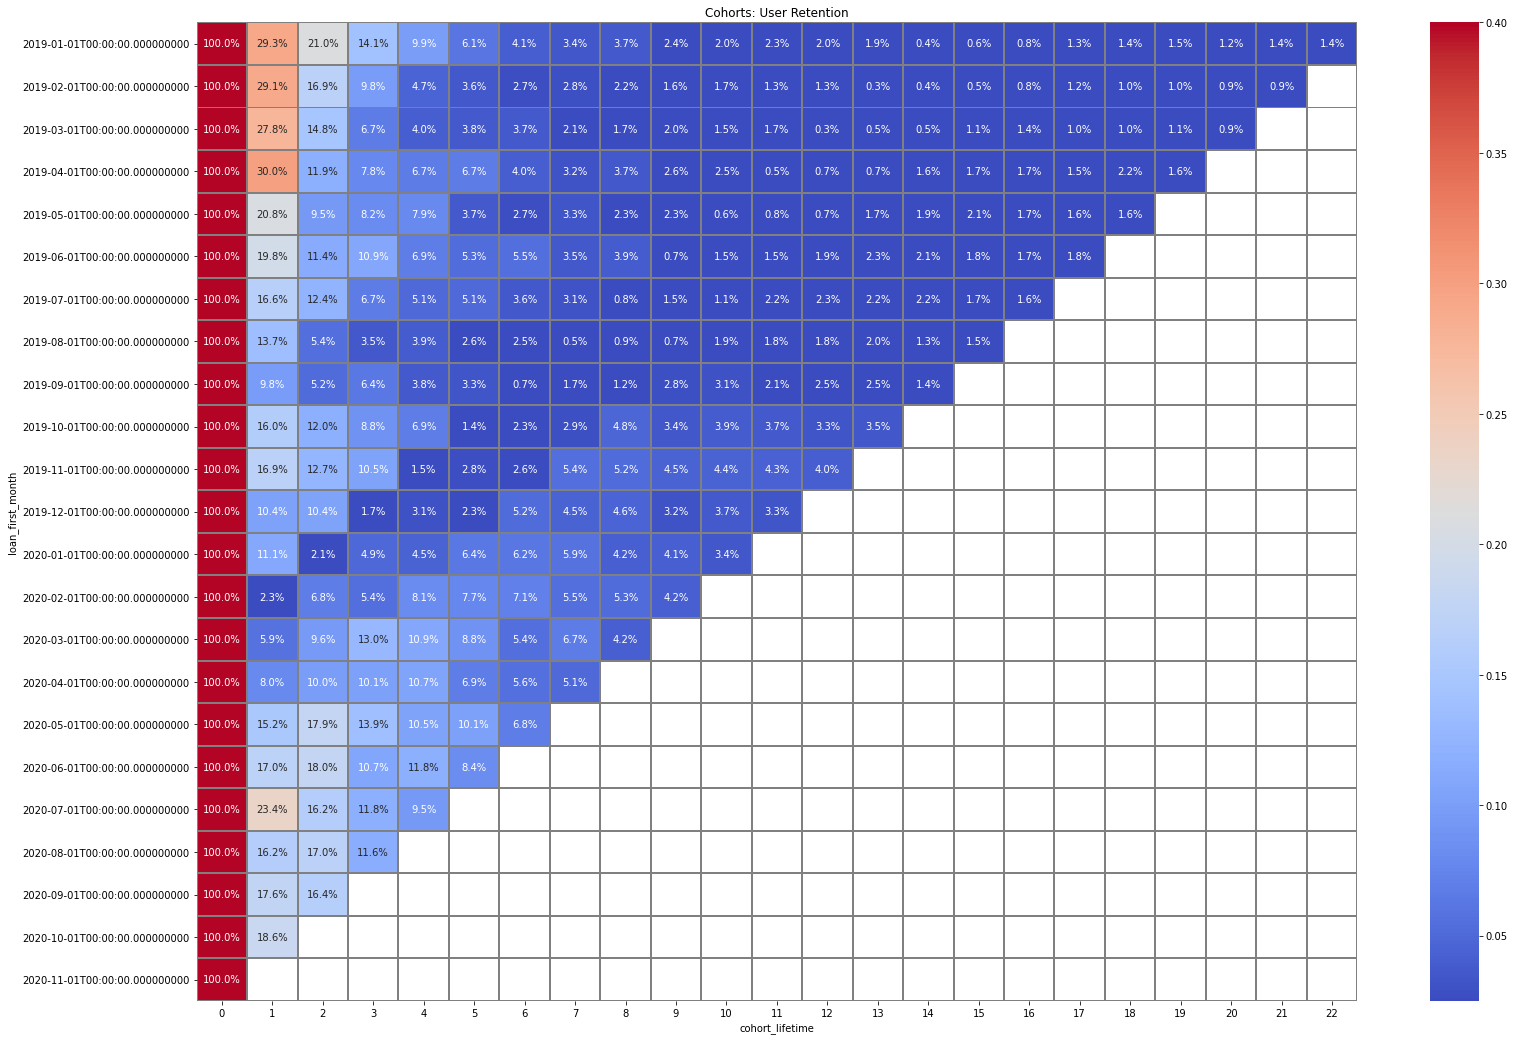

In [54]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.4, vmin=0.025);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>в начале и середине 2019 года мы видим достаточно хороший ретеншен в месяцах 0-1-2
        <li>затем, примерно в авгуте 2019 показатели стали ухудшаться и ретеншен 1 месяца опустился до 20%, а затем и вовсе до 15%
        <li>однако сейчас снова наблюдается рост, начиная с мая 2020
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [55]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,14045,11051,1.27
1,2019-01-01,1,4005,11051,0.36
2,2019-01-01,2,2895,11051,0.26
3,2019-01-01,3,1918,11051,0.17
4,2019-01-01,4,1274,11051,0.12


In [56]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

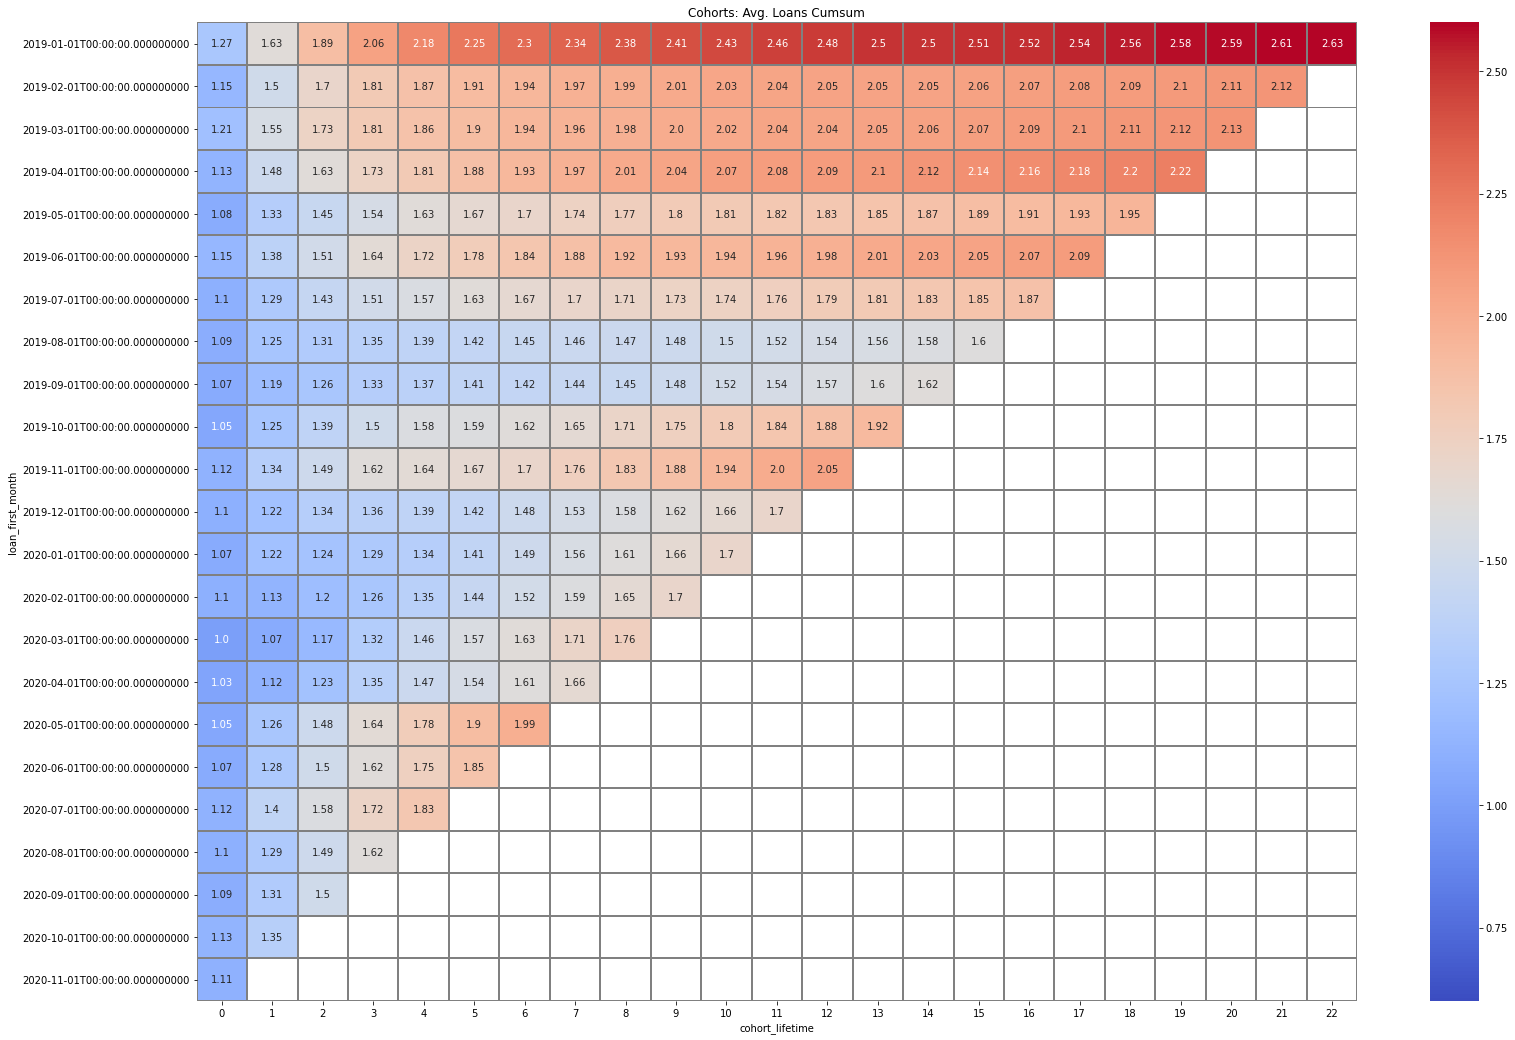

In [57]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.6, vmax=2.6);

#### 5.3 ARPU (Average Revenue per User)

In [58]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,155680200.0,11051,14.09
1,2019-01-01,1,48129300.0,11051,4.36
2,2019-01-01,2,36083500.0,11051,3.27
3,2019-01-01,3,24873800.0,11051,2.25
4,2019-01-01,4,17131031.4,11051,1.55


In [59]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

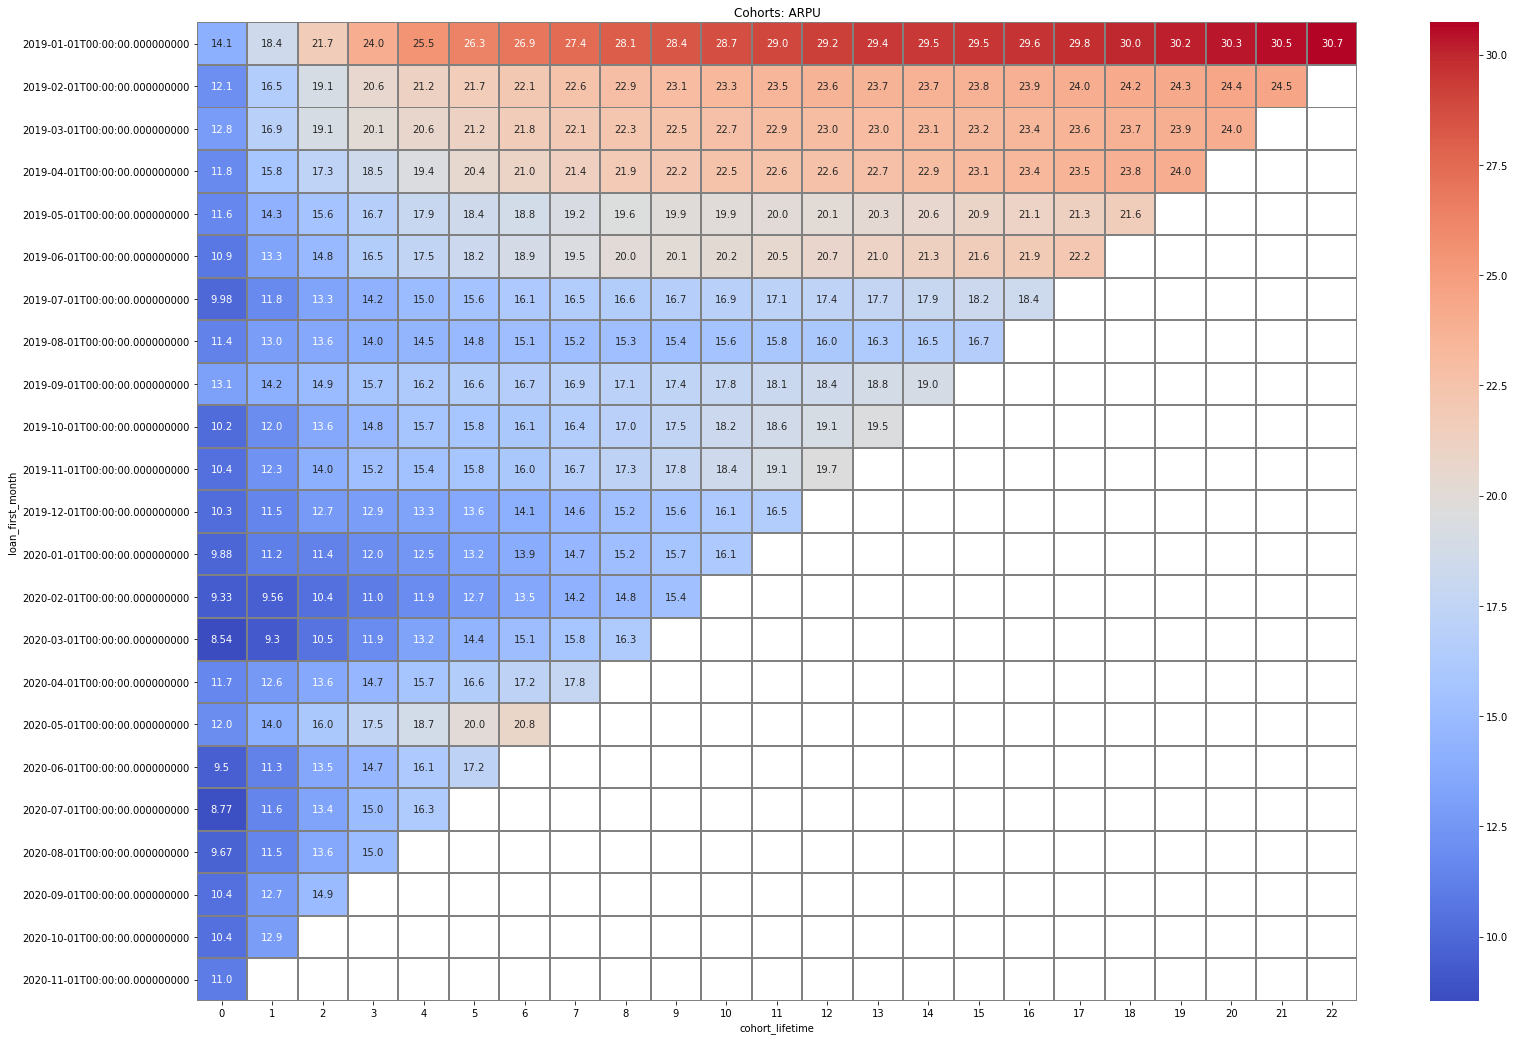

In [60]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [61]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,155680200.0,14045,11.08
1,2019-01-01,1,48129300.0,4005,12.02
2,2019-01-01,2,36083500.0,2895,12.46
3,2019-01-01,3,24873800.0,1918,12.97
4,2019-01-01,4,17131031.4,1274,13.45


In [62]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

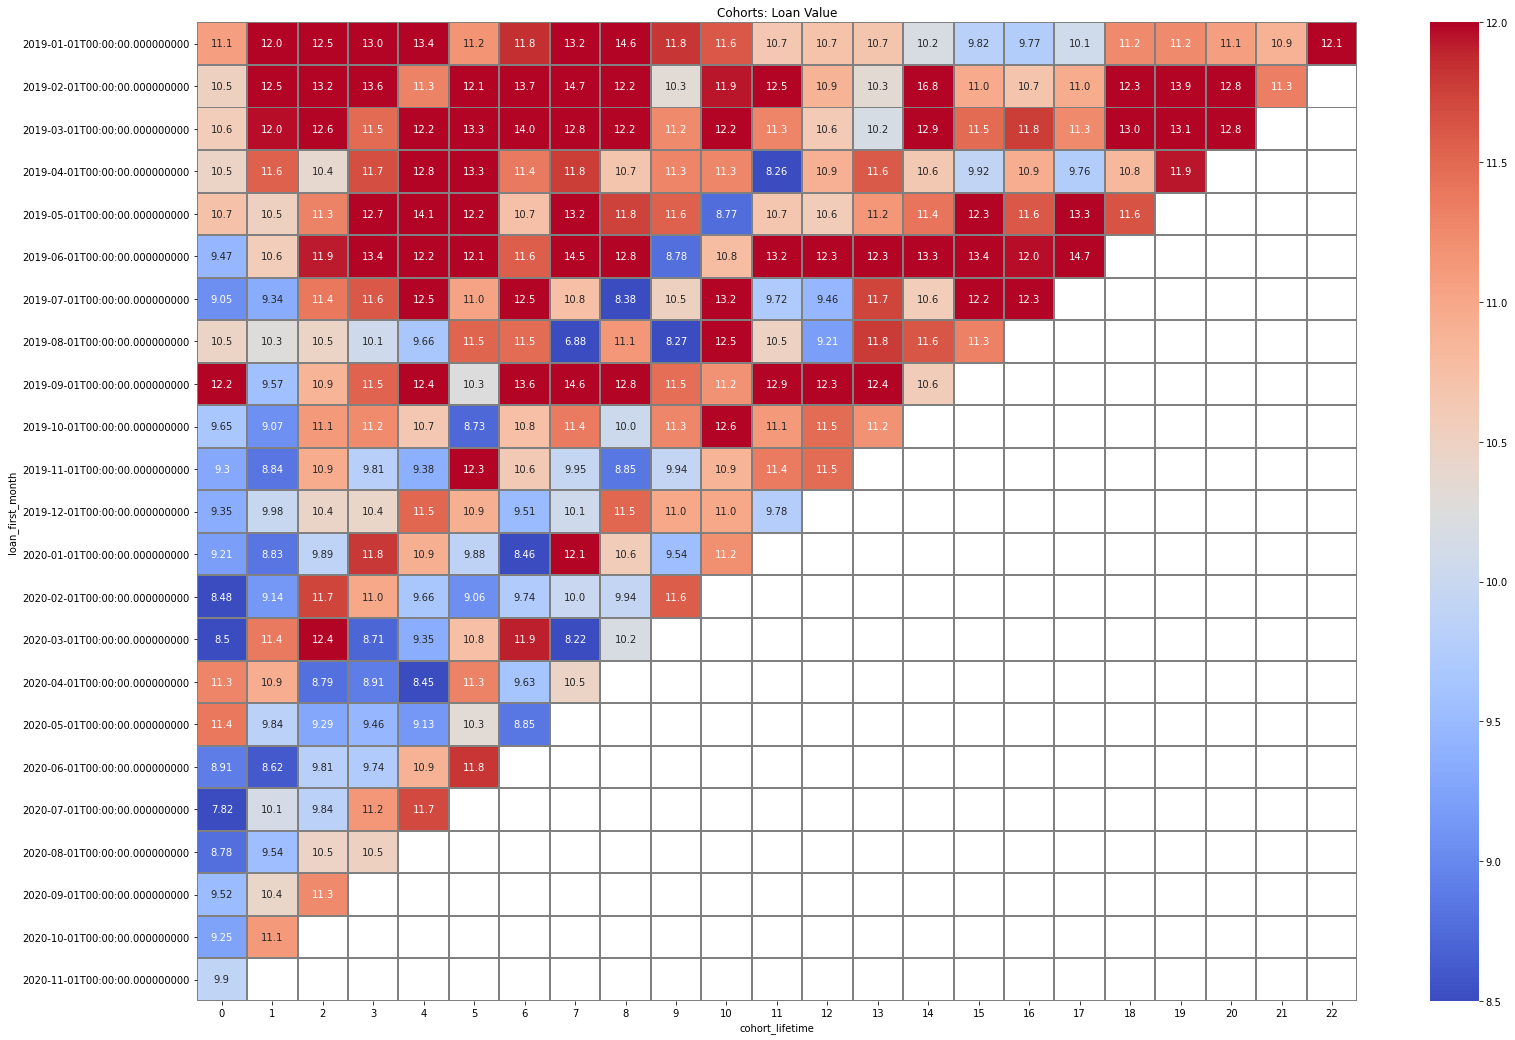

In [63]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=12);

#### 5.4 Средняя сумма займа накопительным итогом

In [64]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,155680200.0,14045,11.08
1,2019-01-01,1,203809500.0,18050,11.29
2,2019-01-01,2,239893000.0,20945,11.45
3,2019-01-01,3,264766800.0,22863,11.58
4,2019-01-01,4,281897831.4,24137,11.68


In [65]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

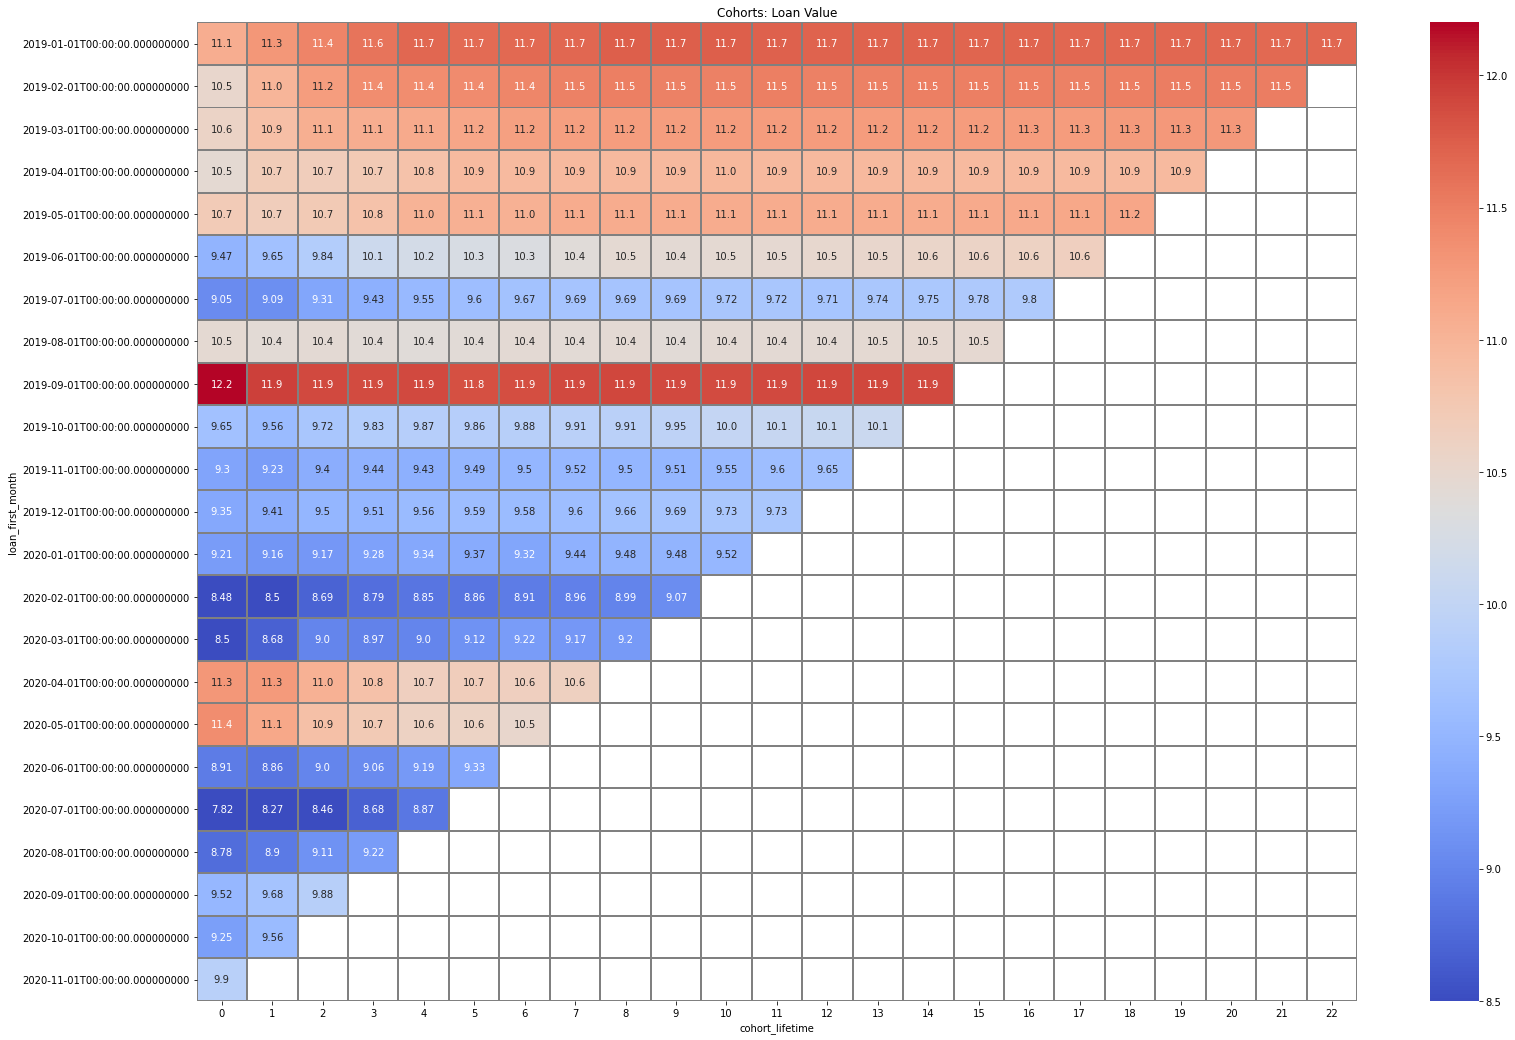

In [66]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=12.2);

#### 5.5 Оборотка нарастающим итогом

In [67]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,15.57
1,2019-01-01,1,4.81
2,2019-01-01,2,3.61
3,2019-01-01,3,2.49
4,2019-01-01,4,1.71
...,...,...,...
271,2020-09-01,1,0.78
272,2020-09-01,2,0.73
273,2020-10-01,0,3.52
274,2020-10-01,1,0.84


In [68]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,15.57
23,2019-02-01,9.13
45,2019-03-01,5.43
66,2019-04-01,4.46
86,2019-05-01,3.51
105,2019-06-01,1.87
123,2019-07-01,3.48
140,2019-08-01,2.28
156,2019-09-01,2.00
171,2019-10-01,1.49


In [69]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,15.57,15.57,1.000000
1,2019-01-01,1,4.81,15.57,0.308927
2,2019-01-01,2,3.61,15.57,0.231856
3,2019-01-01,3,2.49,15.57,0.159923
4,2019-01-01,4,1.71,15.57,0.109827
5,2019-01-01,5,0.91,15.57,0.058446
6,2019-01-01,6,0.65,15.57,0.041747
7,2019-01-01,7,0.57,15.57,0.036609
8,2019-01-01,8,0.68,15.57,0.043674
9,2019-01-01,9,0.37,15.57,0.023764


In [70]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

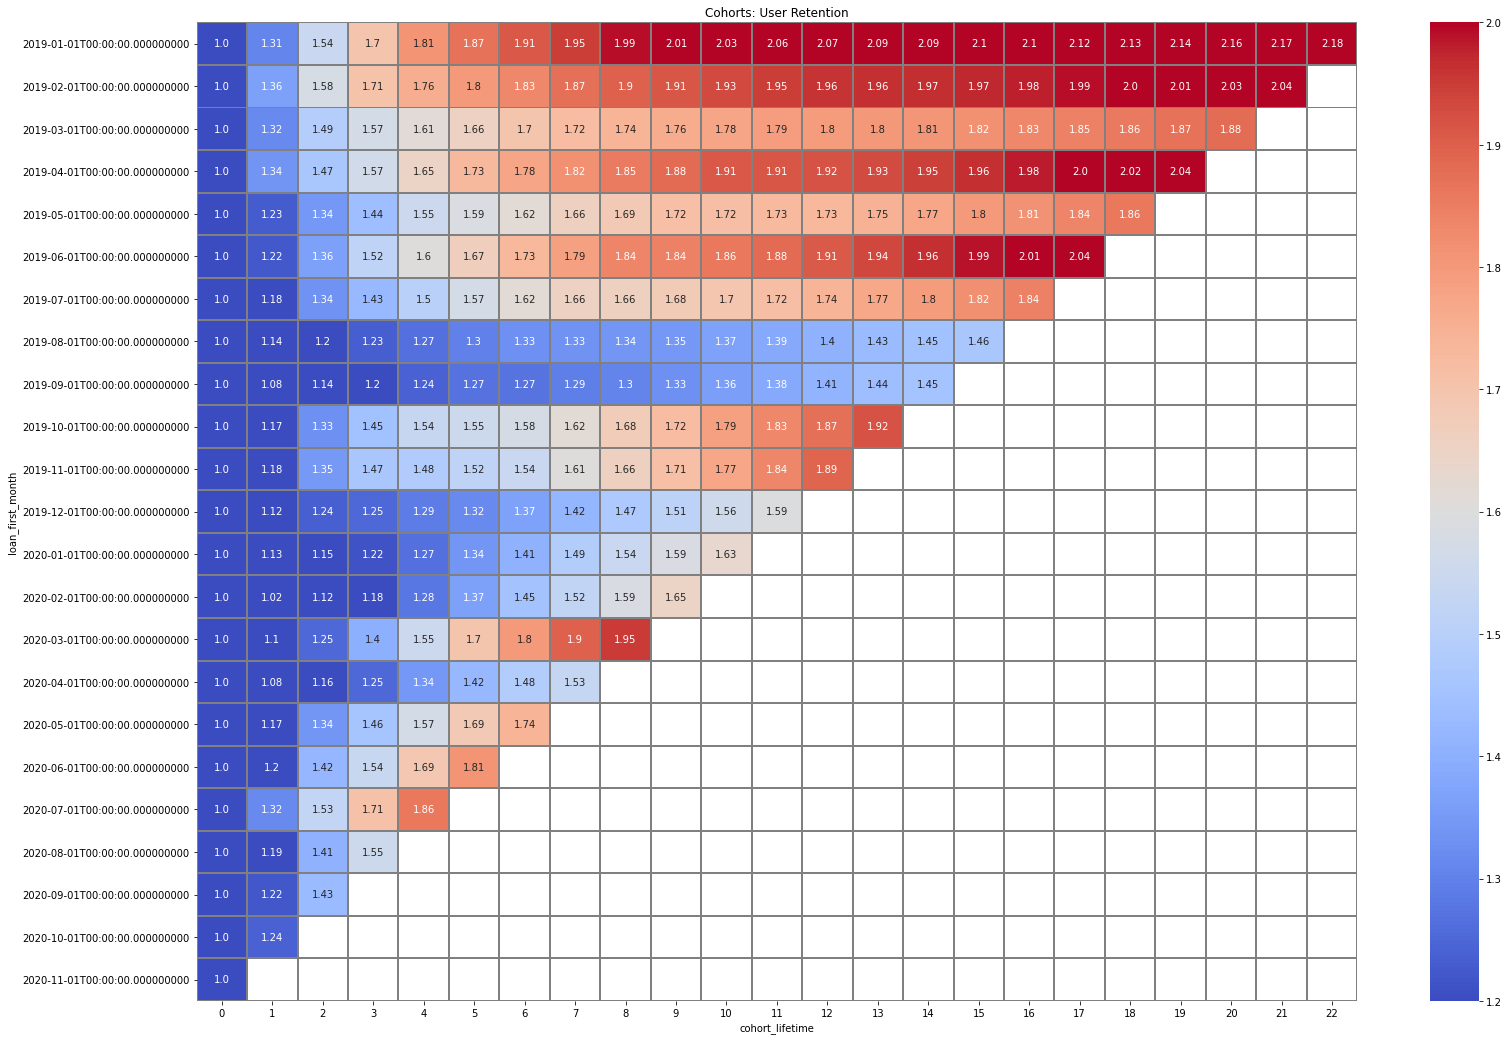

In [71]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=1.2, vmax=2);

In [72]:
loans['end_month'] = loans['end_ts'].astype('datetime64[M]')
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,764990,2019-01-01,17000.0,14,Погашен,2019-01-14,2019-01-01,2018-12-31,2019-01-01,13.0,Досрочно,2019-01-01,0,2019-01-01
1,764990,2019-01-16,20000.0,8,Погашен,2019-01-24,2019-01-16,2019-01-14,2019-01-01,8.0,В срок,2019-01-01,0,2019-01-01
2,764990,2019-01-25,20000.0,16,Погашен,2019-02-09,2019-01-25,2019-01-21,2019-01-01,15.0,Досрочно,2019-01-01,0,2019-02-01
3,875870,2019-01-01,8000.0,30,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01,NaN,Не закрыт,2019-01-01,0,NaT
4,646072,2019-01-01,12000.0,30,Погашен,2019-01-21,2019-01-01,2018-12-31,2019-01-01,20.0,Досрочно,2019-01-01,0,2019-01-01


In [73]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,14045
1,2019-01-01,1,18050
2,2019-01-01,2,20945
3,2019-01-01,3,22863
4,2019-01-01,4,24137


In [74]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,4489
1,2019-01-01,1,9822
2,2019-01-01,2,13071
3,2019-01-01,3,15195
4,2019-01-01,4,16549


In [75]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = (output['paid_loans'] / output['get_loans'])
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

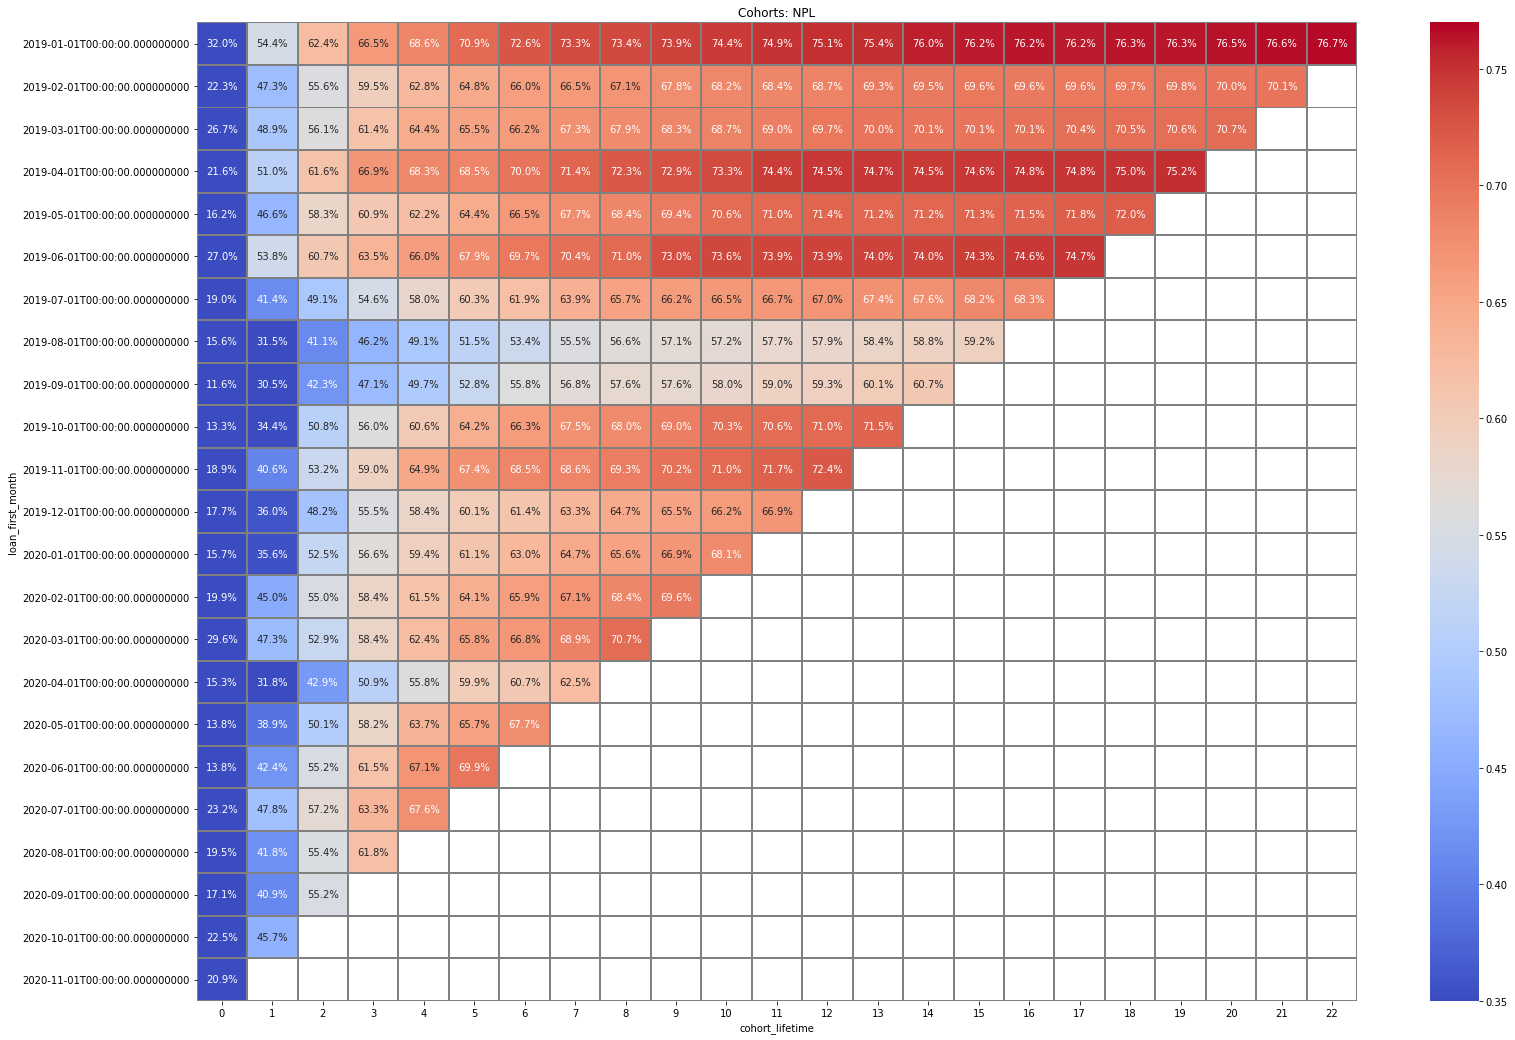

In [76]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.35, vmax=0.77);